In [1]:
cd eda

/Users/cmougan/Desktop/Novartis2021/eda


In [33]:
# %% Imports
import pandas as pd

pd.set_option("display.max_columns", None)
import sys
import numpy as np

sys.path.append("../")
from metrics.metric_participants import ComputeMetrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
import random

from sktools import QuantileEncoder
from category_encoders import TargetEncoder
import shap

from checker import check_train_test

random.seed(0)


sales_train = pd.read_csv("../data/data_raw/sales_train.csv")
df_full = pd.read_csv("../data/split.csv")
df_region = pd.read_csv("../data/data_raw/regions.csv")
regions_hcps = pd.read_csv("../data/data_raw/regions_hcps.csv")
activity_features = pd.read_csv("../data/features/activity_features.csv")
brands_3_12 = pd.read_csv("../data/features/brand_3_12_market_features_lagged.csv")
rte_basic = pd.read_csv("../data/features/rte_basic_features.csv")

In [34]:
# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)

df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)

In [35]:
df_feats.head()

,month,region,brand,sales,validation,population,area_x,pci16_x,pci18_x,area_y,pci16_y,pci18_y,Internal medicine,Internal medicine / pneumology,General practicioner,Internal medicine and general practicioner,Pediatrician,count,null_tiers,inverse_tier,count_f2f,count_other,count_phone,count_video,null_tiers_f2f,null_tiers_other,null_tiers_phone,null_tiers_video,inverse_tier_f2f,inverse_tier_other,inverse_tier_phone,inverse_tier_video,count_General practicioner,count_Internal medicine,count_Internal medicine / pneumology,count_Internal medicine and general practicioner,count_Pediatrician,null_tiers_General practicioner,null_tiers_Internal medicine,null_tiers_Internal medicine / pneumology,null_tiers_Internal medicine and general practicioner,null_tiers_Pediatrician,inverse_tier_General practicioner,inverse_tier_Internal medicine,inverse_tier_Internal medicine / pneumology,inverse_tier_Internal medicine and general practicioner,inverse_tier_Pediatrician,count_3m,null_tiers_3m,inverse_tier_3m,count_f2f_3m,count_other_3m,count_phone_3m,count_video_3m,null_tiers_f2f_3m,null_tiers_other_3m,null_tiers_phone_3m,null_tiers_video_3m,inverse_tier_f2f_3m,inverse_tier_other_3m,inverse_tier_phone_3m,inverse_tier_video_3m,count_General practicioner_3m,count_Internal medicine_3m,count_Internal medicine / pneumology_3m,count_Internal medicine and general practicioner_3m,count_Pediatrician_3m,null_tiers_General practicioner_3m,null_tiers_Internal medicine_3m,null_tiers_Internal medicine / pneumology_3m,null_tiers_Internal medicine and general practicioner_3m,null_tiers_Pediatrician_3m,inverse_tier_General practicioner_3m,inverse_tier_Internal medicine_3m,inverse_tier_Internal medicine / pneumology_3m,inverse_tier_Internal medicine and general practicioner_3m,inverse_tier_Pediatrician_3m,sales_brand_3,sales_brand_3_market,sales_brand_12_market,sales_brand_3shift1,sales_brand_3shift2,sales_brand_3shift3,sales_brand_3shift4,sales_brand_3shift5,sales_brand_3shift6,sales_brand_3shift7,sales_brand_3shift8,sales_brand_3shift9,sales_brand_3shift10,sales_brand_3shift11,sales_brand_3_marketshift1,sales_brand_3_marketshift2,sales_brand_3_marketshift3,sales_brand_3_marketshift4,sales_brand_3_marketshift5,sales_brand_3_marketshift6,sales_brand_3_marketshift7,sales_brand_3_marketshift8,sales_brand_3_marketshift9,sales_brand_3_marketshift10,sales_brand_3_marketshift11,sales_brand_12_marketshift1,sales_brand_12_marketshift2,sales_brand_12_marketshift3,sales_brand_12_marketshift4,sales_brand_12_marketshift5,sales_brand_12_marketshift6,sales_brand_12_marketshift7,sales_brand_12_marketshift8,sales_brand_12_marketshift9,sales_brand_12_marketshift10,sales_brand_12_marketshift11,whichBrand
0,2020-07,region_0,brand_1,0.00,0.0,381958,1372.440545,38799.972381,40214.895762,1372.440545,38799.972381,40214.895762,315,18,264,2,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56588.26,933648.41,501181.82,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,253743.06,1
1,2020-07,region_0,brand_2,0.00,0.0,381958,1372.440545,38799.972381,40214.895762,1372.440545,38799.972381,40214.895762,315,18,264,2,82,15.0,4.0,20.0,14.0,NaN,1.0,NaN,4.0,NaN,0.0,NaN,18.0,NaN,2.0,NaN,2.0,NaN,11.0,NaN,2.0,2.0,NaN,0.0,NaN,2.0,0.0,NaN,20.0,NaN,0.0,15.0,4.0,20.0,14.0,NaN,1.0,NaN,4.0,NaN,0.0,NaN,18.0,NaN,2.0,NaN,2.0,NaN,11.0,NaN,2.0,2.0,NaN,0.0,NaN,2.0,0.0,NaN,20.0,NaN,0.0,56588.26,933648.41,501181.82,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,21170.93,466011.67,466011.67,466011.67,466011.67,466011.67,466011.67,466

In [37]:
df_feats.head()

,month,region,brand,sales_x,validation_x,population,area_x,pci16_x,pci18_x,area_y,pci16_y,pci18_y,Internal medicine,Internal medicine / pneumology,General practicioner,Internal medicine and general practicioner,Pediatrician,count,null_tiers,inverse_tier,count_f2f,count_other,count_phone,count_video,null_tiers_f2f,null_tiers_other,null_tiers_phone,null_tiers_video,inverse_tier_f2f,inverse_tier_other,inverse_tier_phone,inverse_tier_video,count_General practicioner,count_Internal medicine,count_Internal medicine / pneumology,count_Internal medicine and general practicioner,count_Pediatrician,null_tiers_General practicioner,null_tiers_Internal medicine,null_tiers_Internal medicine / pneumology,null_tiers_Internal medicine and general practicioner,null_tiers_Pediatrician,inverse_tier_General practicioner,inverse_tier_Internal medicine,inverse_tier_Internal medicine / pneumology,inverse_tier_Internal medicine and general practicioner,inverse_tier_Pediatrician,count_3m,null_tiers_3m,inverse_tier_3m,count_f2f_3m,count_other_3m,count_phone_3m,count_video_3m,null_tiers_f2f_3m,null_tiers_other_3m,null_tiers_phone_3m,null_tiers_video_3m,inverse_tier_f2f_3m,inverse_tier_other_3m,inverse_tier_phone_3m,inverse_tier_video_3m,count_General practicioner_3m,count_Internal medicine_3m,count_Internal medicine / pneumology_3m,count_Internal medicine and general practicioner_3m,count_Pediatrician_3m,null_tiers_General practicioner_3m,null_tiers_Internal medicine_3m,null_tiers_Internal medicine / pneumology_3m,null_tiers_Internal medicine and general practicioner_3m,null_tiers_Pediatrician_3m,inverse_tier_General practicioner_3m,inverse_tier_Internal medicine_3m,inverse_tier_Internal medicine / pneumology_3m,inverse_tier_Internal medicine and general practicioner_3m,inverse_tier_Pediatrician_3m,sales_brand_3,sales_brand_3_market,sales_brand_12_market,sales_brand_3shift1,sales_brand_3shift2,sales_brand_3shift3,sales_brand_3shift4,sales_brand_3shift5,sales_brand_3shift6,sales_brand_3shift7,sales_brand_3shift8,sales_brand_3shift9,sales_brand_3shift10,sales_brand_3shift11,sales_brand_3_marketshift1,sales_brand_3_marketshift2,sales_brand_3_marketshift3,sales_brand_3_marketshift4,sales_brand_3_marketshift5,sales_brand_3_marketshift6,sales_brand_3_marketshift7,sales_brand_3_marketshift8,sales_brand_3_marketshift9,sales_brand_3_marketshift10,sales_brand_3_marketshift11,sales_brand_12_marketshift1,sales_brand_12_marketshift2,sales_brand_12_marketshift3,sales_brand_12_marketshift4,sales_brand_12_marketshift5,sales_brand_12_marketshift6,sales_brand_12_marketshift7,sales_brand_12_marketshift8,sales_brand_12_marketshift9,sales_brand_12_marketshift10,sales_brand_12_marketshift11,whichBrand,sales_y,validation_y,tier_openings,no. openings,hcp_distinct,tier_openings_General practicioner,tier_openings_Internal medicine,tier_openings_Internal medicine / pneumology,tier_openings_Internal medicine and general practicioner,tier_openings_Pediatrician,no. openings_General practicioner,no. openings_Internal medicine,no. openings_Internal medicine / pneumology,no. openings_Internal medicine and general practicioner,no. openings_Pediatrician,hcp_distinct_General practicioner,hcp_distinct_Internal medicine,hcp_distinct_Internal medicine / pneumology,hcp_distinct_Internal medicine and general practicioner,hcp_distinct_Pediatrician,tier_openings_general,tier_openings_product_related,tier_openings_regional events,no. openings_general,no. openings_product_related,no. openings_regional events,hcp_distinct_general,hcp_distinct_product_related,hcp_distinct_regional events
0,2020-07,region_0,brand_1,0.00,0.0,381958,1372.440545,38799.972381,40214.895762,1372.440545,38799.972381,40214.895762,315,18,264,2,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56588.26,933648.41,501181.82,21170.93,21170.9

In [39]:
rte_basic.columns

Index(['month', 'region', 'brand', 'sales', 'validation', 'tier_openings',
       'no. openings', 'hcp_distinct', 'tier_openings_General practicioner',
       'tier_openings_Internal medicine',
       'tier_openings_Internal medicine / pneumology',
       'tier_openings_Internal medicine and general practicioner',
       'tier_openings_Pediatrician', 'no. openings_General practicioner',
       'no. openings_Internal medicine',
       'no. openings_Internal medicine / pneumology',
       'no. openings_Internal medicine and general practicioner',
       'no. openings_Pediatrician', 'hcp_distinct_General practicioner',
       'hcp_distinct_Internal medicine',
       'hcp_distinct_Internal medicine / pneumology',
       'hcp_distinct_Internal medicine and general practicioner',
       'hcp_distinct_Pediatrician', 'tier_openings_general',
       'tier_openings_product_related', 'tier_openings_regional events',
       'no. openings_general', 'no. openings_product_related',
       'no. openin

In [38]:
rte_basic.head()

,month,region,brand,sales,validation,tier_openings,no. openings,hcp_distinct,tier_openings_General practicioner,tier_openings_Internal medicine,tier_openings_Internal medicine / pneumology,tier_openings_Internal medicine and general practicioner,tier_openings_Pediatrician,no. openings_General practicioner,no. openings_Internal medicine,no. openings_Internal medicine / pneumology,no. openings_Internal medicine and general practicioner,no. openings_Pediatrician,hcp_distinct_General practicioner,hcp_distinct_Internal medicine,hcp_distinct_Internal medicine / pneumology,hcp_distinct_Internal medicine and general practicioner,hcp_distinct_Pediatrician,tier_openings_general,tier_openings_product_related,tier_openings_regional events,no. openings_general,no. openings_product_related,no. openings_regional events,hcp_distinct_general,hcp_distinct_product_related,hcp_distinct_regional events
0,2020-07,region_0,brand_1,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-07,region_0,brand_2,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-07,region_1,brand_1,0.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-07,region_1,brand_2,143.74,1.0,42.0,74.0,107.0,26.0,4.0,12.0,0.0,0.0,55.0,15.0,4.0,0.0,0.0,76.0,28.0,2.0,1.0,0.0,0.0,42.0,0.0,0.0,74.0,0.0,0.0,107.0,0.0
4,2020-07,region_2,brand_1,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df_feats = df_feats.merge(rte_basic, on=["month", "region", "brand"], how="left")

In [32]:
brands_3_12.groupby("region")[""].sum()

,sales_brand_3,sales_brand_3_market,sales_brand_12_market,sales_brand_3shift1,sales_brand_3shift2,sales_brand_3shift3,sales_brand_3shift4,sales_brand_3shift5,sales_brand_3shift6,sales_brand_3shift7,sales_brand_3shift8,sales_brand_3shift9,sales_brand_3shift10,sales_brand_3shift11,sales_brand_3_marketshift1,sales_brand_3_marketshift2,sales_brand_3_marketshift3,sales_brand_3_marketshift4,sales_brand_3_marketshift5,sales_brand_3_marketshift6,sales_brand_3_marketshift7,sales_brand_3_marketshift8,sales_brand_3_marketshift9,sales_brand_3_marketshift10,sales_brand_3_marketshift11,sales_brand_12_marketshift1,sales_brand_12_marketshift2,sales_brand_12_marketshift3,sales_brand_12_marketshift4,sales_brand_12_marketshift5,sales_brand_12_marketshift6,sales_brand_12_marketshift7,sales_brand_12_marketshift8,sales_brand_12_marketshift9,sales_brand_12_marketshift10,sales_brand_12_marketshift11
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
region_0,1117086.86,18755013.60,10666956.92,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,419272.65,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,9424433.34,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60,5335440.60
region_1,853640.54,12009449.36,6803632.80,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,1117086.86,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,18755013.60,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92,10666956.92
region_10,690812.59,9788176.16,5437642.05,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,853640.54,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,12009449.36,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80,6803632.80
region_100,983263.58,9785426.51,5342599.84,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,690812.59,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,9788176.16,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05,5437642.05
region_101,305195.99,6556976.63,3954334.49,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,983263.58,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,9785426.51,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84,5342599.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
region_95,756825.71,10353095.01,5409466.07,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,2568877.53,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,18378745.73,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56,9655376.56
region_96,622755.71,9753944.64,5974509.31,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,756825.71,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,10353095.01,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07,5409466.07
region_97,1118121.18,9503692.59,4901265.54,622755.71,622755.71,622755.71,622755.

In [28]:
# For reproducibility
random.seed(0)
VAL_SIZE = 38
SUBMISSION_NAME = "first_lightgbm"

In [29]:
# %% Add region data
df_feats = df_full.merge(df_region, on="region", how="left")
df_feats = pd.merge(left=df_feats, right=regions_hcps, how="left", on="region")
df_feats = df_feats.merge(
    activity_features, on=["month", "region", "brand"], how="left"
)
df_feats = df_feats.merge(brands_3_12, on=["month", "region"], how="left")

SyntaxError: unmatched ')' (<ipython-input-29-9b67f88e5035>, line 6)

In [23]:
df_feats["whichBrand"] = np.where(df_feats.brand == "brand_1", 1, 0)

In [24]:
df_feats.brand.unique()

array(['brand_1', 'brand_2'], dtype=object)

In [25]:
df_feats.whichBrand.value_counts()

1    2814
0    2814
Name: whichBrand, dtype: int64

In [26]:
df_feats.brand.value_counts()

brand_1    2814
brand_2    2814
Name: brand, dtype: int64

In [197]:
aux = sales_train[
    (sales_train.brand == "brand_12_market") | (sales_train.brand == "brand_3_market")
]

In [198]:
aux[] = aux.groupby(['month','region','brand']).sales.agg(['sum']).reset_index()


In [200]:
ls

010_analysis.py           022_baseline_lgbm.py      __pycache__/
011_dirty_baseline.py     031_Dummy.py              checker.py
020_baseline_simple.py    031_Linear_regression.py  rolling_means.py
021_baseline.py           __init__.py


In [242]:
data = pd.read_csv("../data/features/brand_3_12_market_features.csv")

In [245]:
data.columns

Index(['month', 'region', 'sales_brand_3', 'sales_brand_3_market',
       'sales_brand_12_market'],
      dtype='object')

In [243]:
def grouped(data, col: str = "", shifter: int = 1):
    aux = data.groupby(["month", "region"])[col].sum().shift(1).reset_index()
    title = col + "shift" + str(shifter)
    aux.columns = ["month", "region", title]

    return pd.merge(data, aux, on=["month", "region"])

In [247]:
for col in ["sales_brand_3", "sales_brand_3_market", "sales_brand_12_market"]:
    for i in range(1, 12):
        data = grouped(data, col=col, shifter=i)

In [252]:
data.to_csv("../data/features/brand_3_12_market_features_lagged.csv", index=False)

In [234]:
data = pd.merge(
    data,
    aux,
    on=["month", "region"],
)

In [235]:
data

,month,region,sales_brand_3,sales_brand_3_market,sales_brand_12_market,sales_brand_3_shift1
0,2020-01,region_0,65007.49,940469.05,509023.69,NaN
1,2020-01,region_1,45929.88,625300.10,344182.42,65007.49
2,2020-01,region_2,49600.98,499457.13,232335.01,55244.40
3,2020-01,region_3,28624.41,413104.96,233121.00,30056.30
4,2020-01,region_4,43625.70,577482.54,275719.49,70406.51
...,...,...,...,...,...,...
4015,2021-08,region_196,27605.27,490316.74,274538.96,17482.12
4016,2021-08,region_197,41339.58,411862.82,197299.43,27605.27
4017,2021-08,region_198,47292.98,536692.55,276255.02,41339.58
4018,2021-08,region_199,39418.50,498491.77,267255.42,47292.98


In [212]:
data.shape

(4020, 5)

In [181]:
aux.groupby(["month", "region", "brand"]).sum.shift(1)

AttributeError: 'function' object has no attribute 'shift'

In [179]:
aux

,month,region,brand,sum,sum1
0,2020-01,region_0,brand_12_market,509023.69,NaN
1,2020-01,region_0,brand_3_market,940469.05,NaN
2,2020-01,region_1,brand_12_market,344182.42,NaN
3,2020-01,region_1,brand_3_market,625300.10,NaN
4,2020-01,region_10,brand_12_market,269164.92,NaN
...,...,...,...,...,...
8035,2021-08,region_97,brand_3_market,377172.49,NaN
8036,2021-08,region_98,brand_12_market,247013.29,NaN
8037,2021-08,region_98,brand_3_market,436073.04,NaN
8038,2021-08,region_99,brand_12_market,283535.62,NaN


In [178]:
aux["sum1"] = aux.groupby(["month", "region", "brand"])["sum"].shift(1)

In [158]:
aux = aux.sort_values(["region", "brand", "month"])

In [167]:
aux.head(30)

,month,region,brand,sum,sum_l1,sum1
0,2020-01,region_0,brand_12_market,509023.69,NaN,NaN
402,2020-02,region_0,brand_12_market,458929.00,522498.60,509023.69
804,2020-03,region_0,brand_12_market,658277.86,496981.12,458929.00
1206,2020-04,region_0,brand_12_market,496981.12,473531.38,658277.86
1608,2020-05,region_0,brand_12_market,473531.38,462831.86,496981.12
2010,2020-06,region_0,brand_12_market,462831.86,501181.82,473531.38
2412,2020-07,region_0,brand_12_market,501181.82,478167.37,462831.86
2814,2020-08,region_0,brand_12_market,478167.37,463424.44,501181.82
3216,2020-09,region_0,brand_12_market,463424.44,509023.69,478167.37
3618,2020-10,region_0,brand_12_market,529006.82,560994.86,463424.44


In [166]:
aux["sum1"] = aux["sum"].shift(1)

In [152]:
def calc_rolling_mean(dataf, column=None, setting="30D"):
    return dataf.groupby(["region", "brand"])["sum"].transform(lambda d: d.shift(1))

In [153]:
aux["sum_l1"] = calc_rolling_mean(aux, column=["month", "region"])

In [154]:
aux = aux.sort_values(["region", "month"])
aux[aux.brand == "brand_12_market"]

,month,region,brand,sum,sum_l1
0,2020-01,region_0,brand_12_market,509023.69,NaN
402,2020-02,region_0,brand_12_market,458929.00,522498.60
804,2020-03,region_0,brand_12_market,658277.86,496981.12
1206,2020-04,region_0,brand_12_market,496981.12,473531.38
1608,2020-05,region_0,brand_12_market,473531.38,462831.86
...,...,...,...,...,...
6430,2021-04,region_99,brand_12_market,313016.71,290113.52
6832,2021-05,region_99,brand_12_market,290113.52,293183.90
7234,2021-06,region_99,brand_12_market,293183.90,283535.62
7636,2021-07,region_99,brand_12_market,286953.99,NaN


In [155]:
aux.g

,month,region,brand,sum,sum_l1
0,2020-01,region_0,brand_12_market,509023.69,NaN
1,2020-01,region_0,brand_3_market,940469.05,893304.75
403,2020-02,region_0,brand_3_market,826222.47,1044868.66
402,2020-02,region_0,brand_12_market,458929.00,522498.60
805,2020-03,region_0,brand_3_market,1146403.99,881440.87
...,...,...,...,...,...
7234,2021-06,region_99,brand_12_market,293183.90,283535.62
7636,2021-07,region_99,brand_12_market,286953.99,NaN
7637,2021-07,region_99,brand_3_market,504113.96,468522.93
8038,2021-08,region_99,brand_12_market,283535.62,285312.66


In [131]:
from tools.rolling import rolling_fn

In [ ]:
subset_df = (
    df[["state", "date", "births"]]
    .assign(date=lambda d: pd.to_datetime(d["date"], format="%Y-%m-%d"))
    .loc[lambda d: d["state"] == "CA"]
    .tail(365 * 2)
)

In [101]:
aux

,month,region,brand,sum,mean,min,max,mean_lag1
0,2020-01,region_0,brand_12_market,509023.69,509023.69,509023.69,509023.69,NaN
7639,2021-08,region_0,brand_3_market,939570.07,939570.07,939570.07,939570.07,509023.69
3217,2020-09,region_0,brand_3_market,861331.01,861331.01,861331.01,861331.01,939570.07
3216,2020-09,region_0,brand_12_market,463424.44,463424.44,463424.44,463424.44,861331.01
2815,2020-08,region_0,brand_3_market,879725.43,879725.43,879725.43,879725.43,463424.44
...,...,...,...,...,...,...,...,...
4822,2020-12,region_99,brand_12_market,290923.36,290923.36,290923.36,290923.36,505720.45
4421,2020-11,region_99,brand_3_market,509647.76,509647.76,509647.76,509647.76,290923.36
4420,2020-11,region_99,brand_12_market,286888.76,286888.76,286888.76,286888.76,509647.76
5627,2021-02,region_99,brand_3_market,462568.08,462568.08,462568.08,462568.08,286888.76


In [ ]:
rnm_cols = dict(size="Size", sum="Sum", mean="Mean", std="Std")
df.set_index(["Category", "Item"]).stack().groupby("Category").agg(
    rnm_cols.keys()
).rename(columns=rnm_cols)

In [24]:
categorical = [
    "Internal medicine",
    "Internal medicine / pneumology",
    "General practicioner",
    "Internal medicine and general practicioner",
    "Pediatrician",
]

In [25]:
# drop sum variables
cols_to_drop = ["month", "region", "brand", "sales", "validation"]


# %% Split train val test
X_train = df_feats.query("validation == 0").drop(columns=cols_to_drop)
y_train = df_feats.query("validation == 0").sales

X_val = df_feats.query("validation == 1").drop(columns=cols_to_drop)
y_val = df_feats.query("validation == 1").sales

X_test = df_feats.query("validation.isnull()", engine="python").drop(
    columns=cols_to_drop
)
y_test = df_feats.query("validation.isnull()", engine="python").sales

check_train_test(X_train, X_val)
check_train_test(X_train, X_test, threshold=0.3)
check_train_test(X_val, X_test)

In [39]:
# %%
lgbms = {}
pipes = {}
train_preds = {}
val_preds = {}
test_preds = {}

for quantile in [0.5, 0.1, 0.9]:

    lgbms[quantile] = LGBMRegressor(
        n_jobs=-1,
        n_estimators=50,
        objective="quantile",
        alpha=quantile,
    )

    pipes[quantile] = Pipeline(
        [
            ("encoder", QuantileEncoder(cols=categorical)),
            ("imputer", SimpleImputer(strategy="median")),
            ("lgb", lgbms[quantile]),
        ]
    )

    # Fit cv model
    pipes[quantile].fit(X_train, y_train)

    train_preds[quantile] = pipes[quantile].predict(X_train)
    val_preds[quantile] = pipes[quantile].predict(X_val)
    test_preds[quantile] = pipes[quantile].predict(X_test)

,population,area_x,pci16_x,pci18_x,area_y,pci16_y,pci18_y,Internal medicine,Internal medicine / pneumology,General practicioner,Internal medicine and general practicioner,Pediatrician,count,null_tiers,inverse_tier,count_f2f,count_other,count_phone,count_video,null_tiers_f2f,null_tiers_other,null_tiers_phone,null_tiers_video,inverse_tier_f2f,inverse_tier_other,inverse_tier_phone,inverse_tier_video,count_General practicioner,count_Internal medicine,count_Internal medicine / pneumology,count_Internal medicine and general practicioner,count_Pediatrician,null_tiers_General practicioner,null_tiers_Internal medicine,null_tiers_Internal medicine / pneumology,null_tiers_Internal medicine and general practicioner,null_tiers_Pediatrician,inverse_tier_General practicioner,inverse_tier_Internal medicine,inverse_tier_Internal medicine / pneumology,inverse_tier_Internal medicine and general practicioner,inverse_tier_Pediatrician,count_3m,null_tiers_3m,inverse_tier_3m,count_f2f_3m,count_other_3m,count_phone_3m,count_video_3m,null_tiers_f2f_3m,null_tiers_other_3m,null_tiers_phone_3m,null_tiers_video_3m,inverse_tier_f2f_3m,inverse_tier_other_3m,inverse_tier_phone_3m,inverse_tier_video_3m,count_General practicioner_3m,count_Internal medicine_3m,count_Internal medicine / pneumology_3m,count_Internal medicine and general practicioner_3m,count_Pediatrician_3m,null_tiers_General practicioner_3m,null_tiers_Internal medicine_3m,null_tiers_Internal medicine / pneumology_3m,null_tiers_Internal medicine and general practicioner_3m,null_tiers_Pediatrician_3m,inverse_tier_General practicioner_3m,inverse_tier_Internal medicine_3m,inverse_tier_Internal medicine / pneumology_3m,inverse_tier_Internal medicine and general practicioner_3m,inverse_tier_Pediatrician_3m
0,381958.0,1372.440545,38799.972381,40214.895762,1372.440545,38799.972381,40214.895762,953.291724,2080.566726,953.291724,735.244279,1769.213333,77.0,43.0,40.0,58.0,4.0,11.0,2.0,34.0,1.0,5.0,0.0,27.0,4.0,8.0,2.0,38.0,17.0,20.0,2.0,2.0,30.0,12.0,0.0,1.0,2.0,4.0,4.0,29.0,0.0,0.0,24.0,10.0,16.0,21.0,3.0,5.0,2.0,10.0,1.0,2.0,0.0,12.0,3.0,4.0,2.0,14.0,7.0,9.0,1.0,2.0,10.0,5.0,0.0,1.0,2.0,1.0,2.0,14.0,0.0,0.0
1,381958.0,1372.440545,38799.972381,40214.895762,1372.440545,38799.972381,40214.895762,953.291724,2080.566726,953.291724,735.244279,1769.213333,15.0,4.0,20.0,14.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0,18.0,4.0,2.0,2.0,2.0,17.0,11.0,2.0,2.0,2.0,12.0,0.0,1.0,2.0,0.0,4.0,20.0,0.0,0.0,15.0,4.0,20.0,14.0,3.0,1.0,2.0,4.0,1.0,0.0,0.0,18.0,3.0,2.0,2.0,2.0,7.0,11.0,1.0,2.0,2.0,5.0,0.0,1.0,2.0,0.0,2.0,20.0,0.0,0.0
2,318026.0,2574.943849,42578.018793,44456.389595,2574.943849,42578.018793,44456.389595,481.783158,461.416711,723.290526,735.244279,481.783158,77.0,43.0,40.0,58.0,4.0,11.0,2.0,34.0,1.0,5.0,0.0,27.0,4.0,8.0,2.0,38.0,17.0,20.0,2.0,2.0,30.0,12.0,0.0,1.0,2.0,4.0,4.0,29.0,0.0,0.0,24.0,10.0,16.0,21.0,3.0,5.0,2.0,10.0,1.0,2.0,0.0,12.0,3.0,4.0,2.0,14.0,7.0,9.0,1.0,2.0,10.0,5.0,0.0,1.0,2.0,1.0,2.0,14.0,0.0,0.0
3,318026.0,2574.943849,42578.018793,44456.389595,2574.943849,42578.018793,44456.389595,481.783158,461.416711,723.290526,735.244279,481.783158,37.0,30.0,6.0,32.0,4.0,5.0,2.0,26.0,1.0,4.0,0.0,6.0,4.0,0.0,2.0,28.0,6.0,2.0,1.0,2.0,24.0,4.0,1.0,1.0,2.0,3.0,1.0,2.0,0.0,0.0,37.0,30.0,6.0,32.0,3.0,5.0,2.0,26.0,1.0,4.0,0.0,6.0,3.0,0.0,2.0,28.0,6.0,2.0,1.0,2.0,24.0,4.0,1.0,1.0,2.0,3.0,1.0,2.0,0.0,0.0
4,343861.0,3639.373478,46856.492170,48564.228841,3639.373478,46856.492170,48564.228841,298.125517,709.715177,356.048941,1283.456910,474.992212,77.0,43.0,40.0,58.0,4.0,11.0,2.0,34.0,1.0,5.0,0.0,27.0,4.0,8.0,2.0,38.0,17.0,20.0,2.0,2.0,30.0,12.0,0.0,1.0,2.0,4.0,4.0,29.0,0.0,0.0,24.0,10.0,16.0,21.0,3.0,5.0,2.0,10.0,1.0,2.0,0.0,12.0,3.0,4.0,2.0,14.0,7.0,9.0,1.0,2.0,10.0,5.0,0.0,1.0,2.0,1.0,2.0,14.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

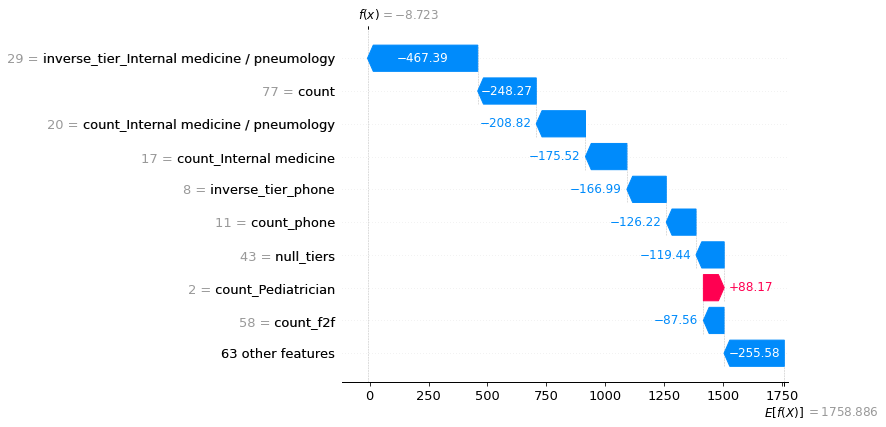

In [48]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(pipes[0.5].named_steps["lgb"])
shap_values = explainer(
    pd.DataFrame(pipe[:-1].transform(X_train), columns=X_train.columns)
)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

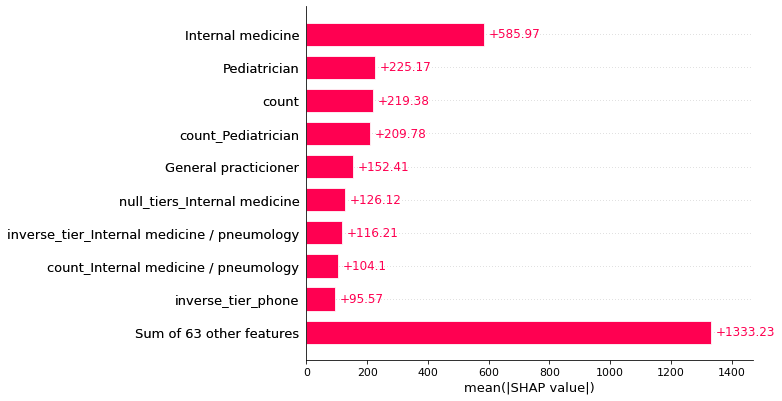

In [49]:
shap.plots.bar(shap_values)

In [22]:
X_train.columns

Index(['count', 'count_other', 'inverse_tier_other', 'count_Pediatrician',
       'count_video', 'Pediatrician', 'area_x',
       'count_Internal medicine / pneumology_3m',
       'inverse_tier_Internal medicine / pneumology_3m'],
      dtype='object')

In [40]:
# %% Train prediction
train_preds_df = (
    df_feats.query("validation == 0")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=train_preds[0.5])
    .assign(lower=train_preds[0.1].clip(0))
    .assign(upper=train_preds[0.9])
)

ground_truth_train = df_feats.query("validation == 0").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(train_preds_df, sales_train, ground_truth_train))

# %% Validation prediction
val_preds_df = (
    df_feats.query("validation == 1")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=val_preds[0.5])
    .assign(lower=val_preds[0.1].clip(0))
    .assign(upper=val_preds[0.9])
)

ground_truth_val = df_feats.query("validation == 1").loc[
    :, ["month", "region", "brand", "sales"]
]

print(ComputeMetrics(val_preds_df, sales_train, ground_truth_val))

# %%
val_preds_df.to_csv(f"../data/validation/{SUBMISSION_NAME}.csv", index=False)


# %% Test prediction
test_preds_df = (
    df_feats.query("validation.isnull()", engine="python")
    .loc[:, ["month", "region", "brand"]]
    .assign(sales=test_preds[0.5])
    .assign(lower=test_preds[0.1].clip(0))
    .assign(upper=test_preds[0.9])
)

test_preds_df.to_csv(f"../submissions/{SUBMISSION_NAME}.csv", index=False)


# %%

# %%

(33.31066999327685, 98.58349196977866)
(66.63760605499311, 218.85801154595615)
